# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
# help(BinaryClassificationPerformance)

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

        
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer(ngram_range=(1,2))
#         hv = HashingVectorizer(n_features=2**18, alternate_sign=False, stop_words='english', ngram_range=(1, 2),lowercase=True)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
#         transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/yaogeezi/Desktop/ml_master/final_assignment_1/moviereviews_train.tsv', my_random_seed=6)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 1513832)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 6689, 'TN': 2442, 'FP': 7568, 'FN': 3301, 'Accuracy': 0.45655, 'Precision': 0.46917303780599007, 'Recall': 0.6695695695695696, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
from sklearn import svm
# svm = linear_model.SGDClassifier()
# svm.fit(X_train, y_train)

# svm_linear_c4 = svm.LinearSVC(loss='hinge', C=0.00004)
svm_linear_c4 = svm.LinearSVC(loss='hinge', C=0.0001)
svm_linear_c4.fit(X_train, y_train)

# svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
# svm_performance_train.compute_measures()
# print(svm_performance_train.performance_measures)

svm_linear_performance_train = BinaryClassificationPerformance(svm_linear_c4.predict(X_train), y_train, 'svm_train')
svm_linear_performance_train.compute_measures()
print(svm_linear_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1000000)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 9990, 'TN': 10010, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9990, 'Neg': 10010, 'TP': 7965, 'TN': 7241, 'FP': 2769, 'FN': 2025, 'Accuracy': 0.7603, 'Precision': 0.7420346562325322, 'Recall': 0.7972972972972973, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

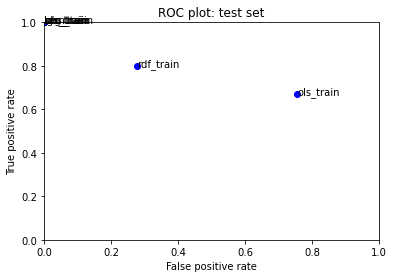

In [12]:
fits = [ols_performance_train, svm_linear_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
118
The name Uwe Boll is automatically linked to bad horror/cult cinema and every new movie he releases  which is about two, three per year  immediately always receives negative ratings and harsh criticism. You're actually almost tempted to think this is just a contemporary hype. You know, like it's popular to hate Uwe Boll whether you liked his movies or not. Let me just assure you that this is NOT the case. Uwe Boll is a terrible writer/director and quite frankly a menace to the entire film-making industry. \Seed\" is another most unfortunate of proof that. In here, Boll tries so desperately hard to come across as controversial and shocking that he overlooks numerous other elements that any movie essentially needs to exist, like a plot, a narrative structure, character development, tension building \"Seed\" is a hideous movie, full of gratuitous filth and incompetent padding footage. I once read that \"Seed\" was Uwe Boll's interpretation of the nowada

2777
note to George Litman, and others: the Mystery Science Theater 3000 riff is \I don't think so, *breeder*\".<br /><br />my favorite riff is \"Why were you looking at his 'like'?\", simply for the complete absurdity. that, and \"Right well did not!\" over all, I would say we must give credit to the MST3K crew for trying to ridicule this TV movie. you really can't make much fun of the dialog; Bill S was a good playwright. on the other hand, this production is so bad that even he would disown it. a junior high school drama club could do better.<br /><br />I would recommend that you buy a book and read 'Hamlet'."
* * * * * * * * * 
2817
Plot is not worth discussion even if it hints at corruption, murder, power and the rest of thriller related topics. Characters are interesting though sometimes. Not realistic but interesting nevertheless.<br /><br />Development is slow like tea drinking ceremony. Visuals not stunning, but good enough to ease the eye strain. Good movie to watch after din

5231
It has very bad acting. Bad story lines. Bad characters. You should never see this show If you see it on. TURN IT OFF. Or you be cringing for the next 30 minutes. It should have never been aired. It's not great. You should never see it. NEVER EVER EVER. So now, if you ever wanna watch this show, please don't. Turn to the THE CW for Smallville. Or Disney Channel for Hannah Montana, Wizards Of Waverly Place, or Nick for Drake & Josh, Those are much better family shows. So believe me on this, I've watched it before. and It is honestly, and I say Honestly, the worst show I've ever seen, and I've seen a lot of TV. So do me a favor, and never watch this show.
* * * * * * * * * 
5298
I remember watching this film back in 86' when it first came out & what an awful film. The acting was atrocious the plot was so flimsy it would or is that should have blew away in a breath of wind. I think it put me to sleep on more than one occasion & i was not tired that i remember. Please avoid at all cos

7588
T.Z. Post, college professor, receives a false letter stating he inherited $750,000. Now with financial means, he withdraws his life savings of $4,000, and decides to finally going out & live. After having his baggage sent on a train to Chicago, he meets a traveling vaudeville troupe, and decides there good enough for him to put on a show on Broadway. The night of the show, poor Prof. Post has to hide from his creditors, settle the relationship woes between girlfriend Pansy and & floozy diva Eleanor, and still make sure the show must go on. After watching many of Keaton's silent gems, this one is a pain to sit through, but I felt, it could have been a lot worse. Supporting cast Durante, Todd, & Selwyn come off very annoying at times, but still likeable. A pre-Charlie Chan Toler is good as the frustrated show director. 90% of the script is badly written as MGM is trying to pass this off as a poor man's Marx Bros. film where many of the sight gags fall flat from the beginning. Compi

9968
Model Chris McCormack (Margaux Hemingway) is brutally raped by a teacher (Chris Sarandon) of her sister Kathy (Mariel Hemingway). He is brought to trial but goes totally free. He then rapes Kathy!<br /><br />Objectionable and sick rape film. This movie was advertised as an important drama dealing with rape. What it is is a badly written and (for the most part) badly acted drama. It purports to be sympathetic to the victim of the rape but shoves the scene in our face. To be totally honest however, Hemingway's acting is so bad in that sequence that it loses any real impact it might have had. The trial scenes were boring and predictable. And the movie just went too far when 15 year old Mariel is raped (thankfully that wasn't shown). I do admit though that it did lead to a great ending when Margaux grabs a gun and shoots Sarandon dead. But seriously--having a young girl raped is just revolting.<br /><br />Acting doesn't help. For instance, Margaux was no actress. She was certainly a b

12129
This movie reminds me of \Irréversible (2002)\", another art-work movie with is a violent and radical approach of human nature. I did not like the movie but I cannot say that it is a bad movie, it is just special. I reminds me also of \"Camping Cosmos (1996)\" where a bunch of low-class figures are residents of a camp at the sea in Belgium. The same description of people living together, side by side against their wills and with all the confrontation of characters that do not match together. I also thought about the books by the French writer Emile Zola who was a writer of the style that is naturalism. I did not like the movie and I also do not like the people who are in it. They all seem so vulgar, without any basic good taste. One could ask the question why do they live, they all seem to be on this planet a a member of a big farce, forced to live against their will. Or you could say: the hell is on this world."
* * * * * * * * * 
12368
This film is really unbelievable. I've see

14445
If you want to see a movie about two utterly unsympathetic characters, this is the one. The acting is superb, both from John Cassavetes as the insane paranoid whom, as the saying goes, they REALLY ARE out to get, and from Peter Falk as his lifelong best friend to whom he turns for rescue. Big mistake, but since they're both amoral mobsters, and misogynistic bastards to boot, it's hard to decide whom to root for LESS. Only writer/director Elaine May could have gotten away with this one. I thought it interesting that in a lengthy interview with producer Michael Hausman included on the DVD, he disclosed that the two stars had \very different ideas\" about the script, that the director was nearly impossible to work with, that the director of photography had impossible demands made of him, that the crew was constantly angry about being made to sit around waiting, and so on. This mood of one big VERY dysfunctional family comes across clearly on the screen."
* * * * * * * * * 
14585
To 

16475
Please Note: I see from the various posts that there was an original silent version and also a sound version of this same film. I saw the sound version and it was esthetically yicky. Considering some indicate that the original version was LONGER and without crappy dubbing, my review must be read with this in mind.<br /><br />Although I know that Rene Clair has a lovely reputation as a film maker and Louise Brooks has a bit of a cult following as well, this is in many ways a technically poorly made film. While Hollywood had already pretty much switched to sound mode around 1929, up through the early to almost the mid-30s, a lot of famous French films were essentially silent films--with some dialog and sound effects very poorly slapped over top the film. The lip movements in many, and in particular this film, don't even come close to matching what is being said and this would explain why an American like Ms. Brooks could do a French film. This is just sloppy and I would have prefer

18419
This one hearkens back to the days of the matinée, when kids with nowhere else to hang out took their dates to the balcony after dumping their younger siblings below. It didn't matter what was on the screen - the little kids would sit through it and the big kids would ignore it. The adults, of course, would never see it.<br /><br />But they put it on video, anyway, along with most of the other creaky, low-budget \B\" horror flicks of the golden age...of television. This film's inherent and unintentional humor is derived from stale ideology (the \"bad girls\" harvested to replace poor Jan's crushed body - they had it comin'), overused plot (a mad scientist, trying to play God), violent yet conscientious monster (whose presence in the heretofore-normal-seeming scientist's rural lab is never fully explained), and acting that polarizes at wooden or over-the-top.<br /><br />This is a great party film, assuming your guests enjoy adding dialog and commentary to otherwise abominable cine

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 1713, 'TN': 572, 'FP': 1918, 'FN': 797, 'Accuracy': 0.457, 'Precision': 0.47177086202148166, 'Recall': 0.6824701195219124, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
# svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
# svm_performance_test.compute_measures()
# print(svm_performance_test.performance_measures)

svm_linear_performance_test = BinaryClassificationPerformance(svm_linear_c4.predict(X_test), y_test, 'svm_test')
svm_linear_performance_test.compute_measures()
print(svm_linear_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2293, 'TN': 2226, 'FP': 264, 'FN': 217, 'Accuracy': 0.9038, 'Precision': 0.8967540086038326, 'Recall': 0.9135458167330678, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2143, 'TN': 2094, 'FP': 396, 'FN': 367, 'Accuracy': 0.8474, 'Precision': 0.8440330838912958, 'Recall': 0.8537848605577689, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2059, 'TN': 2148, 'FP': 342, 'FN': 451, 'Accuracy': 0.8414, 'Precision': 0.8575593502707205, 'Recall': 0.8203187250996016, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2124, 'TN': 2088, 'FP': 402, 'FN': 386, 'Accuracy': 0.8424, 'Precision': 0.8408551068883611, 'Recall': 0.846215139442231, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 2283, 'TN': 2200, 'FP': 290, 'FN': 227, 'Accuracy': 0.8966, 'Precision': 0.8872910998834046, 'Recall': 0.9095617529880478, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2510, 'Neg': 2490, 'TP': 1955, 'TN': 1753, 'FP': 737, 'FN': 555, 'Accuracy': 0.7416, 'Precision': 0.7262258543833581, 'Recall': 0.7788844621513944, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

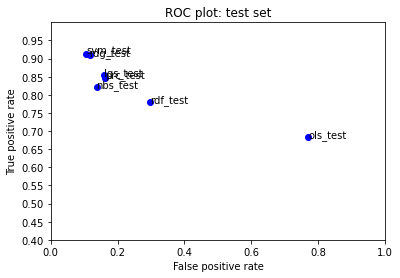

In [22]:
fits = [ols_performance_test, svm_linear_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=6, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 1513832)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Siz

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm_linear_c4.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49728


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_third_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation